In [3]:


# ============================================================================
# Projeto: Predição de Mortes por Tuberculose Utilizando Aprendizado de Máquina
# Autor: Tales Hernandes
# RA: 10408846
# E-mail: 10408846
#
# Descrição:
# Notebook para o 2º Bimestre (N2) - Desenvolvimento, Resultados e Relatório Completo.
# Contém: EDA básica, preparação de dados, modelagem (Linear, Ridge, Lasso,
# Random Forest), validação, métricas, visualizações e exportação de artefatos.
#
# Histórico de alterações:
# - 22/09/2025, Tales Hernandes: Criação do notebook com EDA e preparação de dados.
# - 18/11/2025, Tales Hernandes: Inclusão de modelos (Linear, Ridge, Lasso, RF),
#   validação, tuning via GridSearchCV, geração de métricas, exportação de modelos.
# ============================================================================

In [12]:
# ----------------------------
# 0) Importações
# ----------------------------
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

import joblib

In [13]:
# ----------------------------
# 1) Configurações iniciais
# ----------------------------
SEED = 42
np.random.seed(SEED)
pd.set_option('display.float_format', '{:,.3f}'.format)

OUTPUT_DIR = "artifacts_n2"
os.makedirs(OUTPUT_DIR, exist_ok=True)

In [6]:
# ----------------------------
# 2) Carregamento do dataset
# ----------------------------
file_path = "all_forms_of_tb_deaths_per_100000_estimated.csv"
df = pd.read_csv(file_path)

print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
display(df.head())


Estatísticas descritivas (2000-2004):
      count       mean        std  min    25%   50%    75%    max
2000  208.0  35.930625  64.591963  0.0  1.375  6.20  32.75  317.0
2001  208.0  35.821346  67.925582  0.0  1.275  5.95  33.50  409.0
2002  209.0  34.958278  66.142903  0.0  1.300  6.90  34.00  376.0
2003  209.0  34.514641  67.088074  0.0  1.400  6.30  32.00  398.0
2004  209.0  33.679426  68.628857  0.0  1.200  5.80  31.00  430.0



Valores ausentes por coluna:
2000    6
2001    6
2002    5
2003    5
2004    5
2005    3
2006    3
2007    3
2008    3
2009    3
2010    1
dtype: int64


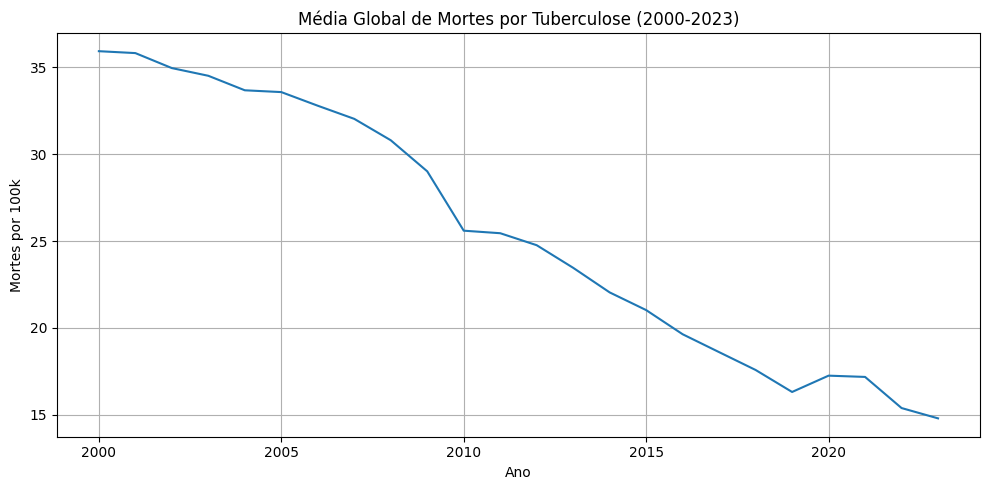

,country,year,deaths_per_100k
5032,Lesotho,2023,229.000
4954,Central African Republic,2023,142.000
4988,Gabon,2023,139.000
4994,Guinea-Bissau,2023,122.000
5057,Namibia,2023,98.000
5047,Myanmar,2023,90.000
5133,South Africa,2023,88.000
5028,Liberia,2023,85.000
4962,"Congo, Rep.",2023,84.000
5102,Eswatini,2023,77.000


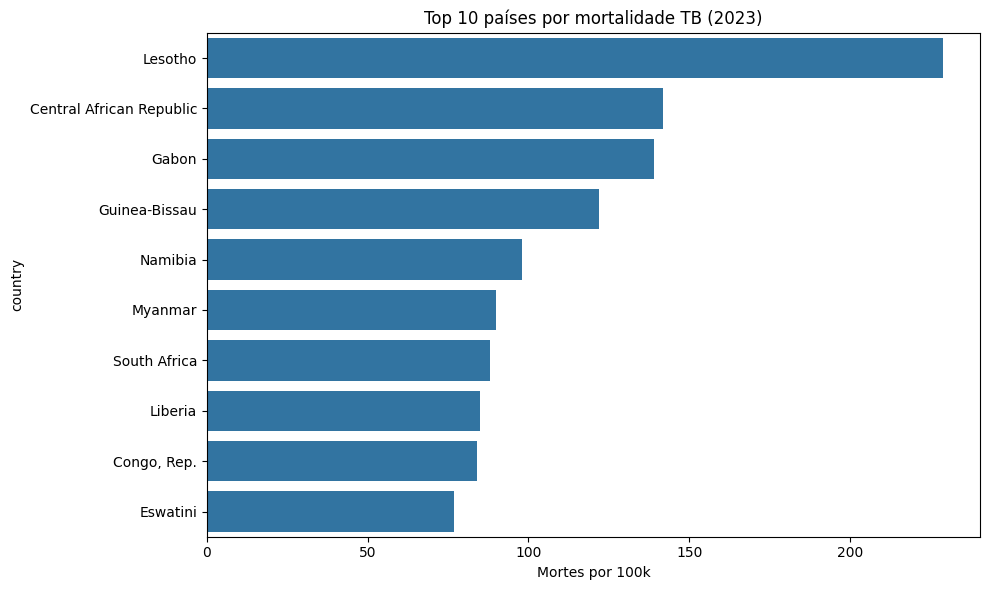

In [14]:
# ----------------------------
# 3) EDA rápida (resumo)
# ----------------------------
# Missing per column
missing = df.isna().sum()
print("\nValores ausentes por coluna:")
print(missing[missing > 0])

df_long = df.melt(id_vars=["country"], var_name="year", value_name="deaths_per_100k")
df_long["year"] = df_long["year"].astype(int)

global_trend = df_long.groupby("year")["deaths_per_100k"].mean()
plt.figure(figsize=(10,5))
sns.lineplot(x=global_trend.index, y=global_trend.values)
plt.title("Média Global de Mortes por Tuberculose (2000-2023)")
plt.xlabel("Ano")
plt.ylabel("Mortes por 100k")
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "global_trend.png"), dpi=150)
plt.show()

top_2023 = df_long[df_long["year"] == 2023].sort_values("deaths_per_100k", ascending=False).head(10)
display(top_2023)
plt.figure(figsize=(10,6))
sns.barplot(x="deaths_per_100k", y="country", data=top_2023)
plt.title("Top 10 países por mortalidade TB (2023)")
plt.xlabel("Mortes por 100k")
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "top10_2023.png"), dpi=150)
plt.show()

In [15]:
# ----------------------------
# 4) Preparação dos dados (pipeline manual)
# ----------------------------
df_pivot = df.set_index("country").copy()

imputer = SimpleImputer(strategy="mean")
df_imputed = pd.DataFrame(imputer.fit_transform(df_pivot),
                          columns=df_pivot.columns,
                          index=df_pivot.index)

years = [str(y) for y in range(2000, 2023)]
target_year = "2023"

X = df_imputed[years].copy()
y = df_imputed[target_year].copy()

print("\nX shape:", X.shape, "y shape:", y.shape)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.20, random_state=SEED)
print("Treino:", X_train.shape, "Teste:", X_test.shape)

joblib.dump(imputer, os.path.join(OUTPUT_DIR, "imputer.joblib"))
joblib.dump(scaler, os.path.join(OUTPUT_DIR, "scaler.joblib"))


X shape: (214, 23) y shape: (214,)
Treino: (171, 23) Teste: (43, 23)


['artifacts_n2/scaler.joblib']

In [18]:
# ----------------------------
# 5) Definição de funções utilitárias
# ----------------------------
def regression_metrics(y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred)) # Fixed: Removed squared=False
    return {"r2": r2, "mae": mae, "rmse": rmse}

def print_metrics(name, y_true, y_pred):
    m = regression_metrics(y_true, y_pred)
    print(f"{name} -> R2: {m['r2']:.4f}, MAE: {m['mae']:.4f}, RMSE: {m['rmse']:.4f}")
    return m

In [19]:
# ----------------------------
# 6) Modelagem: Baseline LinearRegression
# ----------------------------
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
metrics_lr = print_metrics("LinearRegression", y_test, y_pred_lr)

cv = KFold(n_splits=5, shuffle=True, random_state=SEED)
cv_scores_lr = cross_val_score(lr, X_scaled, y, cv=cv, scoring='r2')
print("LinearRegression CV R2 (5-fold):", np.mean(cv_scores_lr).round(4))

LinearRegression -> R2: 0.8669, MAE: 4.3038, RMSE: 9.9527
LinearRegression CV R2 (5-fold): 0.896


In [20]:
# ----------------------------
# 7) Regularized models (Ridge, Lasso) com GridSearchCV
# ----------------------------
# Ridge
ridge = Ridge(random_state=SEED)
ridge_params = {"alpha": [0.01, 0.1, 1.0, 10.0, 100.0]}
gs_ridge = GridSearchCV(ridge, ridge_params, cv=cv, scoring='r2', n_jobs=-1)
gs_ridge.fit(X_train, y_train)
best_ridge = gs_ridge.best_estimator_
y_pred_ridge = best_ridge.predict(X_test)
metrics_ridge = print_metrics("Ridge (best)", y_test, y_pred_ridge)
print("Ridge best params:", gs_ridge.best_params_)
print("Ridge CV best score:", gs_ridge.best_score_.round(4))

# Lasso
lasso = Lasso(random_state=SEED, max_iter=10000)
lasso_params = {"alpha": [0.0001, 0.001, 0.01, 0.1, 1.0]}
gs_lasso = GridSearchCV(lasso, lasso_params, cv=cv, scoring='r2', n_jobs=-1)
gs_lasso.fit(X_train, y_train)
best_lasso = gs_lasso.best_estimator_
y_pred_lasso = best_lasso.predict(X_test)
metrics_lasso = print_metrics("Lasso (best)", y_test, y_pred_lasso)
print("Lasso best params:", gs_lasso.best_params_)
print("Lasso CV best score:", gs_lasso.best_score_.round(4))

Ridge (best) -> R2: 0.9455, MAE: 2.9753, RMSE: 6.3662
Ridge best params: {'alpha': 1.0}
Ridge CV best score: 0.9382
Lasso (best) -> R2: 0.9628, MAE: 2.8046, RMSE: 5.2622
Lasso best params: {'alpha': 1.0}
Lasso CV best score: 0.9385


In [21]:
# ----------------------------
# 8) Random Forest Regressor com GridSearchCV
# ----------------------------
rf = RandomForestRegressor(random_state=SEED)
rf_params = {
    "n_estimators": [100, 200],
    "max_depth": [5, 10, None],
    "min_samples_split": [2, 5]
}
gs_rf = GridSearchCV(rf, rf_params, cv=cv, scoring='r2', n_jobs=-1, verbose=1)
gs_rf.fit(X_train, y_train)
best_rf = gs_rf.best_estimator_
y_pred_rf = best_rf.predict(X_test)
metrics_rf = print_metrics("RandomForest (best)", y_test, y_pred_rf)
print("RF best params:", gs_rf.best_params_)
print("RF CV best score:", gs_rf.best_score_.round(4))

Fitting 5 folds for each of 12 candidates, totalling 60 fits
RandomForest (best) -> R2: 0.9000, MAE: 4.0012, RMSE: 8.6279
RF best params: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 100}
RF CV best score: 0.833


In [22]:
# ----------------------------
# 9) Comparação de modelos - tabela de métricas
# ----------------------------
results = pd.DataFrame({
    "model": ["LinearRegression", "Ridge", "Lasso", "RandomForest"],
    "r2": [metrics_lr["r2"], metrics_ridge["r2"], metrics_lasso["r2"], metrics_rf["r2"]],
    "mae": [metrics_lr["mae"], metrics_ridge["mae"], metrics_lasso["mae"], metrics_rf["mae"]],
    "rmse": [metrics_lr["rmse"], metrics_ridge["rmse"], metrics_lasso["rmse"], metrics_rf["rmse"]]
})
display(results.sort_values("r2", ascending=False))

# Save results
results.to_csv(os.path.join(OUTPUT_DIR, "model_metrics.csv"), index=False)


,model,r2,mae,rmse
2,Lasso,0.963,2.805,5.262
1,Ridge,0.946,2.975,6.366
3,RandomForest,0.900,4.001,8.628
0,LinearRegression,0.867,4.304,9.953


Melhor modelo segundo R2: Lasso


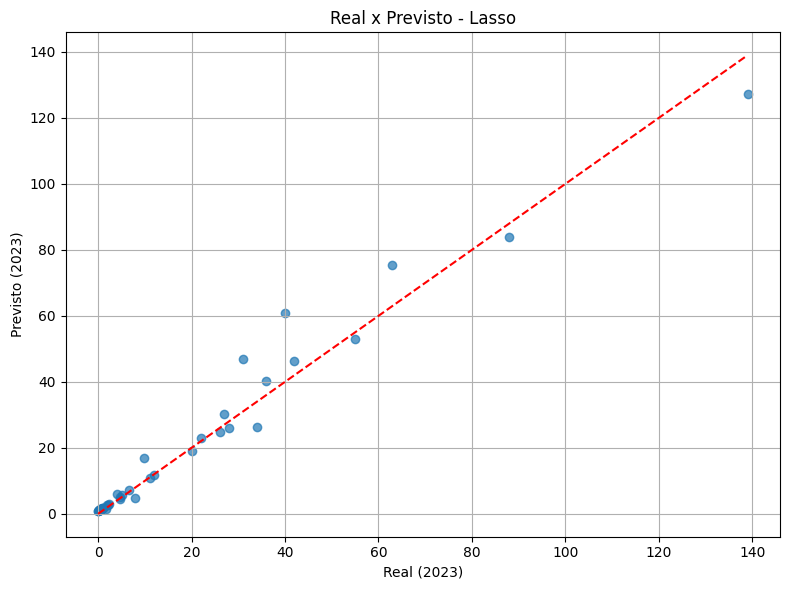

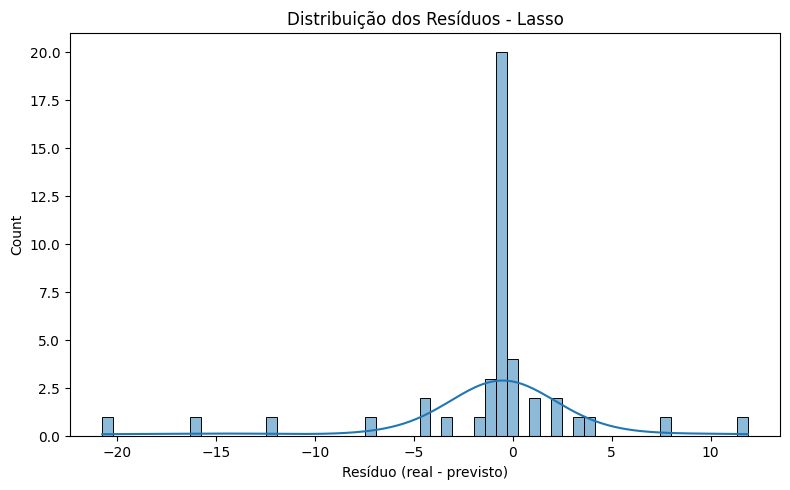

In [23]:
# ----------------------------
# 10) Visualizações: real x previsto (melhor modelo)
# ----------------------------
best_model_name = results.sort_values("r2", ascending=False).iloc[0]["model"]
print("Melhor modelo segundo R2:", best_model_name)

if best_model_name == "RandomForest":
    y_pred_best = y_pred_rf
    best_model = best_rf
elif best_model_name == "Ridge":
    y_pred_best = y_pred_ridge
    best_model = best_ridge
elif best_model_name == "Lasso":
    y_pred_best = y_pred_lasso
    best_model = best_lasso
else:
    y_pred_best = y_pred_lr
    best_model = lr

plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred_best, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Real (2023)")
plt.ylabel("Previsto (2023)")
plt.title(f"Real x Previsto - {best_model_name}")
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "real_vs_predicted_best.png"), dpi=150)
plt.show()

residuals = y_test - y_pred_best
plt.figure(figsize=(8,5))
sns.histplot(residuals, kde=True)
plt.title(f"Distribuição dos Resíduos - {best_model_name}")
plt.xlabel("Resíduo (real - previsto)")
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "residuals_best.png"), dpi=150)
plt.show()

In [24]:
# ----------------------------
# 11) Importância de features (se aplicável)
# ----------------------------
if hasattr(best_model, "feature_importances_"):
    importances = best_model.feature_importances_
    feat_imp = pd.DataFrame({"feature": years, "importance": importances})
    feat_imp = feat_imp.sort_values("importance", ascending=False).head(10)
    plt.figure(figsize=(10,6))
    sns.barplot(x="importance", y="feature", data=feat_imp)
    plt.title("Top 10 features mais importantes")
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, "feature_importance.png"), dpi=150)
    plt.show()
    display(feat_imp)
else:
    print("Modelo escolhido não oferece feature_importances_ (ex.: regressão linear)")

Modelo escolhido não oferece feature_importances_ (ex.: regressão linear)


In [29]:
# ----------------------------
# 12) Exportar modelos e previsões
# ----------------------------
joblib.dump(best_model, os.path.join(OUTPUT_DIR, f"best_model_{best_model_name}.joblib"))

X_scaled_df = pd.DataFrame(X_scaled, index=df_imputed.index, columns=years)

from sklearn.model_selection import ShuffleSplit
ss = ShuffleSplit(n_splits=1, test_size=0.20, random_state=SEED)
train_idx, test_idx = next(ss.split(X_scaled_df))
test_countries = X_scaled_df.index[test_idx]

pred_df = pd.DataFrame({
    "country": test_countries,
    "real_2023": y.loc[test_countries].values,
    "pred_2023": y_pred_best
})
pred_df["error_abs"] = (pred_df["real_2023"] - pred_df["pred_2023"]).abs()

pred_df = pred_df.sort_values("error_abs", ascending=False)
display(pred_df.head(20))
pred_df.to_csv(os.path.join(OUTPUT_DIR, "predictions_test_set.csv"), index=False)

,country,real_2023,pred_2023,error_abs
3,Timor-Leste,40.000,60.767,20.767
31,Nigeria,31.000,47.066,16.066
13,Equatorial Guinea,63.000,75.305,12.305
2,Gabon,139.000,127.124,11.876
28,Sao Tome and Principe,34.000,26.371,7.629
25,Lao,9.900,16.986,7.086
38,Kenya,42.000,46.418,4.418
34,Ghana,36.000,40.174,4.174
22,South Africa,88.000,83.989,4.011
1,Tanzania,27.000,30.209,3.209
